###  Comparison between best Deep Learning Models for Tabular data  using *mushroom_cleaned* dataset

I'm going to use these models:
- #### TabTransforner
- #### TabNet
- #### CatBoost
- #### XGBoost

For each model I will get the execution time, loss, Test  Accuracy and their parameters archiving a minimum of .85 in val accuracy.

Every model have a training-testing size --> 80-20 with a random_seed=42, an *ADAM optimizer* and a *BCEWwithLogistLoss loss function*

#### Imports

In [9]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#
import torch
import torch.nn as nn
# Models
from tab_transformer_pytorch import TabTransformer
# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [10]:
results = {
    'Model': [],
    'Training Time (s)': [],
    'Test Accuracy': [],
    'AUC' : []
}

#### Load Data

In [85]:
dataset = pd.read_csv('mushroom_cleaned.csv', sep=',')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


##### Data treatment common for each model

In [86]:
categorical_cols = ['cap-diameter','cap-shape', 'gill-attachment', 'gill-color', 'stem-width', 'stem-color']
continuous_cols = ['stem-height', 'season']
label_col = 'class'
#
labelEncodersTabTransformer = {}
#
for col in categorical_cols: 
    le = LabelEncoder();
    dataset[col] = le.fit_transform(dataset[col])
    labelEncodersTabTransformer[col] = le
# Split data into 'data' and 'labels'
X = dataset.drop(label_col, axis=1)
y = dataset[label_col]
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Separate categorical and continous features
X_train_cat =   X_train[categorical_cols].values
X_train_cont =  X_train[continuous_cols].values
#
X_test_cat =    X_test[categorical_cols].values
X_test_cont =   X_test[continuous_cols].values
#
# Convert to PyTorch Tensors
X_train_cat_tensor =    torch.tensor(X_train_cat,       dtype=torch.long)
X_train_cont_tensor =   torch.tensor(X_train_cont,      dtype=torch.float)
y_train_tensor =        torch.tensor(y_train.values,    dtype=torch.float)
# 
X_test_cat_tensor =     torch.tensor(X_test_cat, dtype=torch.long)
X_test_cont_tensor =    torch.tensor(X_test_cont, dtype=torch.float)
y_test_tensor =         torch.tensor(y_test.values, dtype=torch.float)

### TabTransformer

#### Define the model + Optimizer + Loss function

In [15]:
# Parameters
NUM_UNIQUE_CATEGORIES = [dataset[col].nunique() for col in categorical_cols]
NUM_CONTINOUS  = len(continuous_cols)
DIM = 32
DIM_OUT = 1
DEPTH = 6
HEADS = 8
ATTN_DROPOUT = .1
FF_DROPOUT = .1

In [16]:
modelTabTrans = TabTransformer(
    categories=NUM_UNIQUE_CATEGORIES,
    num_continuous=NUM_CONTINOUS,
    dim=DIM,
    dim_out=DIM_OUT,
    depth=DEPTH,
    heads=HEADS,
    attn_dropout=ATTN_DROPOUT,
    ff_dropout=FF_DROPOUT
)

In [17]:
# Optimizer + Loss function
optimizer = torch.optim.Adam(modelTabTrans.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

#### TabTransformer Train

In [18]:
loss_TabTrans = [] # loss per epoch
ini_time = time.time()
modelTabTrans.train()
for epoch in range(15):
    optimizer.zero_grad()
    output = modelTabTrans(X_train_cat_tensor, X_train_cont_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_TabTrans.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
training_time_TabTransformer = time.time() - ini_time

Epoch 1, Loss: 0.7031704783439636
Epoch 2, Loss: 0.7093916535377502
Epoch 3, Loss: 0.6453656554222107
Epoch 4, Loss: 0.6308826804161072
Epoch 5, Loss: 0.6224784255027771
Epoch 6, Loss: 0.5909332633018494
Epoch 7, Loss: 0.5672847628593445
Epoch 8, Loss: 0.5623806118965149
Epoch 9, Loss: 0.5410106778144836
Epoch 10, Loss: 0.5209521055221558
Epoch 11, Loss: 0.5130075216293335
Epoch 12, Loss: 0.49755892157554626
Epoch 13, Loss: 0.4814178943634033
Epoch 14, Loss: 0.4703806936740875
Epoch 15, Loss: 0.4514971971511841


#### TabTransformer Evaluation

In [19]:
modelTabTrans.eval()
with torch.no_grad():
    # Test Loss
    test_output = modelTabTrans(X_test_cat_tensor, X_test_cont_tensor)
    test_loss = criterion(test_output.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')
    # Accuracy
    test_preds = torch.sigmoid(test_output).squeeze().round()
    accuracy = accuracy_score(y_test_tensor.numpy(), y_test_tensor)
    print(f'Test Accuracy: {accuracy * 100:.4f}%')
    # AUC
    test_probs = torch.sigmoid(test_output).squeeze().numpy()
    fpr_tabtrans, tpr_tabtrans, _ = roc_curve(y_test, test_probs)
    roc_auc_tabtrns = roc_auc_score(y_test, test_probs)
    print(f'Test AUC: {roc_auc_tabtrns:.4f}')

Test Loss: 0.4310368597507477
Test Accuracy: 100.0000%
Test AUC: 0.8836


Guardamos todo en el diccionario resultados

In [20]:
results['Model'].append('TabTransformer')
results['Training Time (s)'].append(training_time_TabTransformer)
results['Test Accuracy'].append(accuracy)
results['AUC'].append(roc_auc_tabtrns)

### TF-Transformer

No tenemos una implementación directa de TF-Transformer en PyTorch o Skleaern.

### SAINT

Importamos SAINT desde nuestra fuente de librerías, si no está descargar la librería desde :
*git clone https://github.com/somepago/saint*

No podemos probar el SAINT ya que es una librería generada para la ejecución de entrenamientos y testeos de modelos tipo SAINT por comando usando aceleración por GPU y no dispongo de los núcleos CUDA suficientes para que sea verdaderamente efectivo

### TabNet

In [21]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [22]:
modelTabNet = TabNetClassifier(
    n_d= 32, n_a=32, n_steps=5, gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=[i for i in range(len(categorical_cols))],
    cat_dims=[dataset[col].nunique() for col in categorical_cols],
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax'
)

/Users/alejandro/Documents/Repositorios/alejandromadrid/.python-venv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [23]:
start_time = time.time()
modelTabNet.fit(
    X_train=np.hstack([X_train_cat, X_train_cont]),
    y_train=y_train.values,
    eval_set=[(np.hstack([X_test_cat, X_test_cont]), y_test.values)],
    eval_name=['test'],
    eval_metric=['auc'],
    max_epochs=10,
    patience=0,
    batch_size=1024,
    virtual_batch_size=128
)
training_time_tabnet = time.time() - start_time

test_probs = modelTabNet.predict_proba(np.hstack([X_test_cat, X_test_cont]))[:, 1]
test_preds = (test_probs > 0.5).astype(int)
accuracy_tabnet = accuracy_score(y_test, test_preds)
print(f'Test Accuracy: {accuracy_tabnet * 100:.2f}%')

fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, test_probs)
roc_auc_tabnet = roc_auc_score(y_test, test_probs)
print(f'Test AUC: {roc_auc_tabnet:.2f}')

/Users/alejandro/Documents/Repositorios/alejandromadrid/.python-venv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.70732 | test_auc: 0.63611 |  0:00:05s
epoch 1  | loss: 0.59771 | test_auc: 0.71279 |  0:00:09s
epoch 2  | loss: 0.55356 | test_auc: 0.79524 |  0:00:13s
epoch 3  | loss: 0.53332 | test_auc: 0.82095 |  0:00:17s
epoch 4  | loss: 0.48863 | test_auc: 0.86548 |  0:00:21s
epoch 5  | loss: 0.45256 | test_auc: 0.88555 |  0:00:26s
epoch 6  | loss: 0.42428 | test_auc: 0.90558 |  0:00:31s
epoch 7  | loss: 0.40643 | test_auc: 0.8989  |  0:00:36s
epoch 8  | loss: 0.39537 | test_auc: 0.91399 |  0:00:40s
epoch 9  | loss: 0.3986  | test_auc: 0.91976 |  0:00:45s
Test Accuracy: 83.11%
Test AUC: 0.92


Guardamos todo en el diccionario

In [25]:
results['Model'].append('TabNet')
results['Training Time (s)'].append(training_time_tabnet)
results['Test Accuracy'].append(accuracy_tabnet)
results['AUC'].append(roc_auc_tabnet)

### Conclusiones

Como no he podido usar los 4 métodos más usados seguiré la lista para hacer una comparación de mínimo 4 métodos.

### LightGMB

Es un algoritmo de alto rendimiento basado en el boosting. Este es un algoritmo conocido por la eficiencia en el entrenamiento

Este algoritmo no me deja ejecutarlo en macOS por problemas que desconozco y la alterativa es ejecutar en Windows o usar contenedores Docker.

### CatBoost

Es un algoritmo que usa el boosting de gradiente desarrollado por Yandex. Se destaca por manejar automáticamente variables categóricas y tiene un buen rendimiento con datos tabulares.

In [27]:
from catboost import CatBoostClassifier

#### Configuramos el modelo

In [28]:
modelCatBoost = CatBoostClassifier (
    iterations=100,
    learning_rate=.05,
    depth=6,
    eval_metric='AUC',
    verbose=10,
    cat_features=categorical_cols
)


#### Entrenamos el modelo

In [29]:
start_time = time.time()
modelCatBoost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)
training_time_catboost = time.time() - start_time

0:	test: 0.8157660	best: 0.8157660 (0)	total: 28ms	remaining: 2.77s
10:	test: 0.8622404	best: 0.8622404 (10)	total: 117ms	remaining: 944ms
20:	test: 0.8850844	best: 0.8850844 (20)	total: 190ms	remaining: 714ms
30:	test: 0.9007778	best: 0.9007778 (30)	total: 262ms	remaining: 583ms
40:	test: 0.9115564	best: 0.9115564 (40)	total: 333ms	remaining: 479ms
50:	test: 0.9190101	best: 0.9190101 (50)	total: 412ms	remaining: 396ms
60:	test: 0.9249647	best: 0.9249647 (60)	total: 500ms	remaining: 319ms
70:	test: 0.9328259	best: 0.9328259 (70)	total: 589ms	remaining: 241ms
80:	test: 0.9383811	best: 0.9383811 (80)	total: 675ms	remaining: 158ms
90:	test: 0.9425015	best: 0.9425015 (90)	total: 752ms	remaining: 74.4ms
99:	test: 0.9454913	best: 0.9454913 (99)	total: 822ms	remaining: 0us

bestTest = 0.9454913263
bestIteration = 99



#### Predicción y evaluación

In [30]:
test_preds = modelCatBoost.predict_proba(X_test)[:,1]
test_preds_binary = (test_preds > .5).astype(int)
accuracy_catboost = accuracy_score(y_test, test_preds_binary)
print(f'Test Accuracy: {accuracy_catboost * 100:.4f}')
#
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, test_preds)
roc_auc_catboost = roc_auc_score(y_test, test_preds)
print(f'Test AUC: {roc_auc_catboost:.4f}')

Test Accuracy: 85.9998
Test AUC: 0.9455


Guardamos todo en results

In [31]:
results['Model'].append('CatBoost')
results['Training Time (s)'].append(training_time_catboost)
results['Test Accuracy'].append(accuracy_catboost)
results['AUC'].append(roc_auc_catboots)

### XGBoost

El XGBoost es un modelo optimizado para el aprendizaje en árboles de decisión.

In [77]:
import xgboost as xbg

#### Preprocess para XGBoost

In [91]:
dtrain =    xbg.DMatrix(X_train, label=y_train)
dtest =     xbg.DMatrix(X_test, label=y_test)

#### Configuración de modelo

In [92]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.05,
    'max_depth': 6
}

In [90]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43228, 8), (10807, 8), (43228,), (10807,))

#### Entrenamiento del modelo

In [93]:
start_time = time.time()
modelXGB = xbg.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10)
training_time_xbg = time.time() - start_time

[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.61461
[5]	eval-logloss:0.60167
[6]	eval-logloss:0.58999
[7]	eval-logloss:0.57763
[8]	eval-logloss:0.56696
[9]	eval-logloss:0.55324
[10]	eval-logloss:0.54317
[11]	eval-logloss:0.53229
[12]	eval-logloss:0.52447
[13]	eval-logloss:0.51285
[14]	eval-logloss:0.50206
[15]	eval-logloss:0.49234
[16]	eval-logloss:0.48669
[17]	eval-logloss:0.47926
[18]	eval-logloss:0.47227
[19]	eval-logloss:0.46424
[20]	eval-logloss:0.45786
[21]	eval-logloss:0.45005
[22]	eval-logloss:0.44383
[23]	eval-logloss:0.43669
[24]	eval-logloss:0.43075
[25]	eval-logloss:0.42516
[26]	eval-logloss:0.41991
[27]	eval-logloss:0.41255
[28]	eval-logloss:0.40787
[29]	eval-logloss:0.40350
[30]	eval-logloss:0.39693
[31]	eval-logloss:0.39266
[32]	eval-logloss:0.38860
[33]	eval-logloss:0.38240
[34]	eval-logloss:0.37805
[35]	eval-logloss:0.37435
[36]	eval-logloss:0.37092
[37]	eval-logloss:0.36764
[38]	eval-logloss:0.36

#### Predicción y evaluación

In [95]:
# Accuracy
test_preds_xgb = modelXGB.predict(dtest)
test_preds_binary_xgb = (test_preds_xgb > .5).astype(int)
accuracy_xgb = accuracy_score(y_test, test_preds_binary_xgb)
# AUC score
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, test_preds_xgb)
roc_auc_xgb = roc_auc_score(y_test, test_preds_xgb)

Guardamos todo en el diccionario

In [96]:
results['Model'].append('XGBoost')
results['Training Time (s)'].append(training_time_xbg)
results['Test Accuracy'].append(accuracy_xgb)
results['AUC'].append(roc_auc_xgb)

### Comparación de Resultados

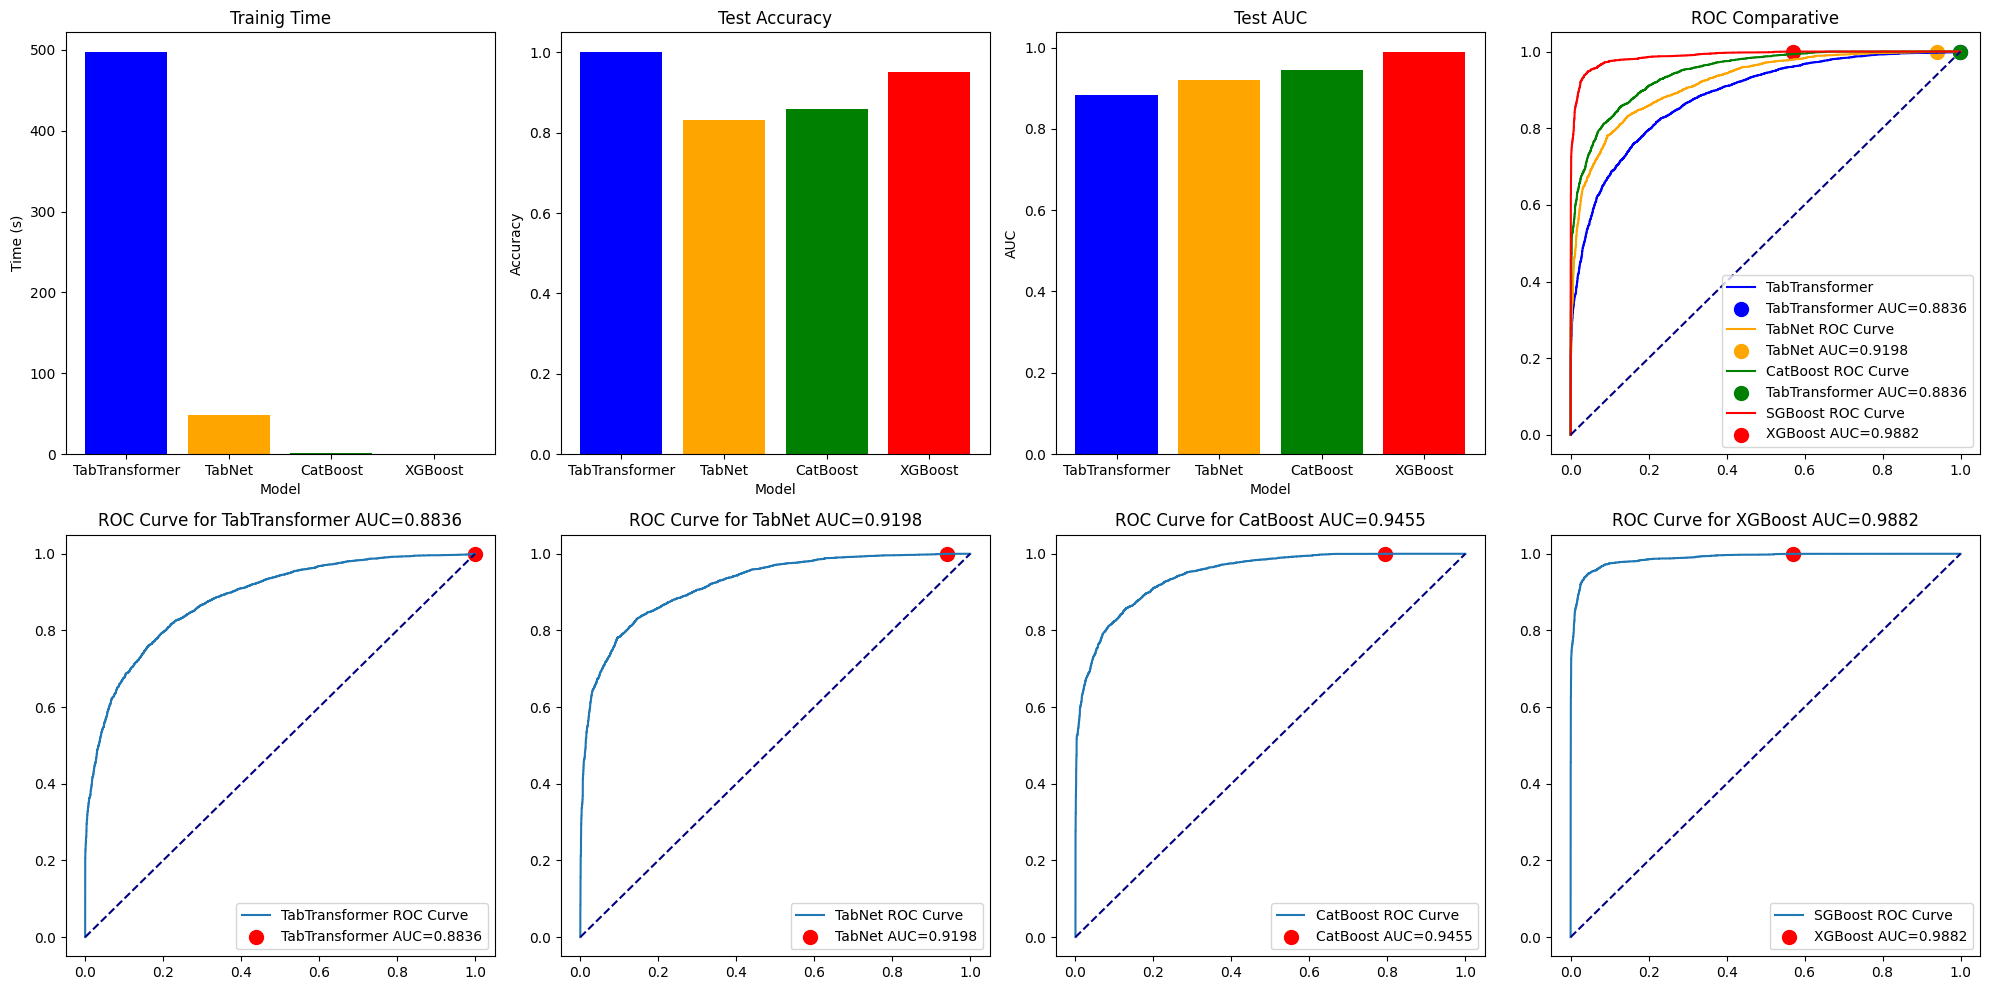

In [105]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'black']
colors_fit = [color for color in colors[:len(results['Model'])]] # Así solo usamos los colores que necesitamos
#
results_df = pd.DataFrame(results)

# Ahora nos hacemos unas gráficas comparativas
fig, axes = plt.subplots(2, 4, figsize=(20,10))

# Tiempos de entrenamiento
axes[0][0].bar(results_df['Model'], results_df['Training Time (s)'], color=colors_fit)
axes[0][0].set_title('Trainig Time')
axes[0][0].set_xlabel('Model')
axes[0][0].set_ylabel('Time (s)')

# Accuracy
axes[0][1].bar(results_df['Model'], results_df['Test Accuracy'], color=colors_fit)
axes[0][1].set_title('Test Accuracy')
axes[0][1].set_xlabel('Model')
axes[0][1].set_ylabel('Accuracy')

# AUC
axes[0][2].bar(results_df['Model'], results_df['AUC'], color=colors_fit)
axes[0][2].set_title('Test AUC')
axes[0][2].set_xlabel('Model')
axes[0][2].set_ylabel('AUC')

# Todas las ROC
axes[0][3].plot(fpr_tabtrans, tpr_tabtrans, label=f'TabTransformer', color='blue')
axes[0][3].scatter([fpr_tabtrans[np.argmax(tpr_tabtrans)]], [tpr_tabtrans[np.argmax(tpr_tabtrans)]], label=f'TabTransformer AUC={roc_auc_tabtrns:.4f}', s=100, marker='o', color='blue')
#
axes[0][3].plot(fpr_tabnet, tpr_tabnet, label=f'TabNet ROC Curve', color='orange')
axes[0][3].scatter([fpr_tabnet[np.argmax(tpr_tabnet)]], [tpr_tabnet[np.argmax(tpr_tabnet)]], label=f'TabNet AUC={roc_auc_tabnet:.4f}', s=100, marker='o', color='orange')
#
axes[0][3].plot(fpr_catboost, tpr_catboost, label=f'CatBoost ROC Curve', color='green')
axes[0][3].scatter([fpr_tabtrans[np.argmax(tpr_tabtrans)]], [tpr_tabtrans[np.argmax(tpr_tabtrans)]], label=f'TabTransformer AUC={roc_auc_tabtrns:.4f}', s=100, marker='o', color='green')
#
axes[0][3].plot(fpr_xgb, tpr_xgb, label=f'SGBoost ROC Curve', color='red')
axes[0][3].scatter([fpr_xgb[np.argmax(tpr_xgb)]], [tpr_xgb[np.argmax(tpr_xgb)]], label=f'XGBoost AUC={roc_auc_xgb:.4f}', s=100, marker='o', color='red')
#
axes[0][3].plot([0,1], [0,1], color='navy', linestyle='--')
axes[0][3].set_title('ROC Comparative')
axes[0][3].legend(loc='lower right')

# Curvas ROC 
# TabTransformer
axes[1][0].plot(fpr_tabtrans, tpr_tabtrans, label=f'TabTransformer ROC Curve')
axes[1][0].plot([0,1], [0,1], color='navy', linestyle='--')
axes[1][0].scatter([fpr_tabtrans[np.argmax(tpr_tabtrans)]], [tpr_tabtrans[np.argmax(tpr_tabtrans)]], label=f'TabTransformer AUC={roc_auc_tabtrns:.4f}', s=100, marker='o', color='red')
axes[1][0].set_title(f'ROC Curve for TabTransformer AUC={roc_auc_tabtrns:.4f}')
axes[1][0].legend(loc='lower right')
# TabNet
axes[1][1].plot(fpr_tabnet, tpr_tabnet, label=f'TabNet ROC Curve')
axes[1][1].scatter([fpr_tabnet[np.argmax(tpr_tabnet)]], [tpr_tabnet[np.argmax(tpr_tabnet)]], label=f'TabNet AUC={roc_auc_tabnet:.4f}', s=100, marker='o', color='red')
axes[1][1].plot([0,1], [0,1], color='navy', linestyle='--')
axes[1][1].set_title(f'ROC Curve for TabNet AUC={roc_auc_tabnet:.4f}')
axes[1][1].legend(loc='lower right')
# CatBoost
axes[1][2].plot(fpr_catboost, tpr_catboost, label=f'CatBoost ROC Curve')
axes[1][2].plot([0,1], [0,1], color='navy', linestyle='--')
axes[1][2].scatter([fpr_catboost[np.argmax(tpr_catboost)]], [tpr_catboost[np.argmax(tpr_catboost)]], label=f'CatBoost AUC={roc_auc_catboost:.4f}', s=100, marker='o', color='red')
axes[1][2].set_title(f'ROC Curve for CatBoost AUC={roc_auc_catboost:.4f}')
axes[1][2].legend(loc='lower right')
# XGBoost
axes[1][3].plot(fpr_xgb, tpr_xgb, label=f'SGBoost ROC Curve')
axes[1][3].plot([0,1], [0,1], color='navy', linestyle='--')
axes[1][3].scatter([fpr_xgb[np.argmax(tpr_xgb)]], [tpr_xgb[np.argmax(tpr_xgb)]], label=f'XGBoost AUC={roc_auc_xgb:.4f}', s=100, marker='o', color='red')
axes[1][3].set_title(f'ROC Curve for XGBoost AUC={roc_auc_xgb:.4f}')
axes[1][3].legend(loc='lower right')

plt.tight_layout()
plt.show()